In [9]:
using ExcelReaders, JuMP, Gurobi, DataFrames, CPLEX, DataFrames, StatPlots

In [2]:
# Sets
G  = ["Diesel","CCGT","Coal","Hydro","Wind"];    # Tecnologias 
P = [i for i=1:670];  # Bloques representativos del año

In [3]:
# Parameters
K = Dict(              # capacida de generador
  "Diesel" => 2000.0,
  "CCGT"   => 5000.0,
  "Coal"   => 9000.0,
  "Hydro"  => 8000.0,
  "Wind"   => 0
);

MC = Dict(              # costos marginales
  "Diesel" => 180,
  "CCGT"   => 60,
  "Coal"   => 30,
  "Hydro"  => 0,
  "Wind"   => 0
);


MCF = Dict(              # factor de planta anual maximo
  "Diesel" => 1.0,
  "CCGT"   => 1.0,
  "Coal"   => 1.0,
  "Hydro"  => 0.37,
    "Wind" => 1.0
);

FOR = Dict(              # tasa de falla del generador
  "Diesel" => 0.0,
  "CCGT"   => 0.0,
  "Coal"   => 0.2,
  "Hydro"  => 0.0,
    "Wind" => 0.0
);

I = Dict(
  "Diesel" => 50000,
  "CCGT"   => 80000,
  "Coal"   => 300000,
  "Hydro"  => 260000,
    "Wind" => 200000
)

E = Dict(
  "Diesel" => 0.75,
  "CCGT"   => 0.50,
  "Coal"   => 1.00,
  "Hydro"  => 0.0,
    "Wind" => 0.0
)

D = readxl("Datos2.xlsx", "Datos P1!B2:B671"); # demanda en el periodo i

W_wind = readxl("Datos2.xlsx", "Datos P1!C2:C671"); # factor de planta maximo por periodo i

W = Dict{Tuple{String,Int64},Float64}();

for i=G,t=P
    try
    W[i,t]
    catch error
       if isa(error, KeyError)
           if i=="Wind"
                W[i,t] = W_wind[t]
           else
                W[i,t] = 1.0
           end
       end
    end
end


VOLL = 500;

H = 8760/670;

In [4]:
# Modelo declaracion
P1 = Model(solver=GurobiSolver(Presolve=0)); # planificacion a largo plazo

# Variables
@variable(P1, q1[G,P] >= 0); # cantidad de energia generada de la tecnologia i en el periodo t
@variable(P1, u1[P] >= 0); # variable desprendimiento
@variable(P1, x1[G] >=0); # capacidad instalada

# funcion objetivo
@objective(P1, :Min, sum(MC[i]*q1[i,t]*H for i in G, t in P) + sum(VOLL*u1[t]*H for t in P) + sum(I[i]*x1[i] for i in G));

# Balance demanda energia
@constraint(P1, balance1[t=P], sum(q1[i,t] for i in G) + u1[t] == 2*D[t]);

# restriccion de capacidad por bloques
@constraint(P1, capacidad1[i=G,t=P], q1[i,t] <= W[i,t]*(K[i]+x1[i])*(1-FOR[i]));

# restriccion de energia maxima anual
@constraint(P1, maximaanual1[i=G], sum(H*q1[i,t] for t in P) <= MCF[i]*(K[i]+x1[i])*sum(H for t in P));

In [5]:
solve(P1)

Academic license - for non-commercial use only
Optimize a model with 4025 rows, 4025 columns and 13965 nonzeros
Coefficient statistics:
  Matrix range     [7e-05, 9e+03]
  Objective range  [4e+02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+07]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.383794e+07   0.000000e+00      0s
    3582    1.3865856e+10   0.000000e+00   0.000000e+00      1s

Solved in 3582 iterations and 0.61 seconds
Optimal objective  1.386585577e+10


:Optimal

# Pregunta 1b

In [6]:
for i in G
    println(@sprintf " %6s   %09.3f" i getvalue(x1[i]))
end

 Diesel   00000.000
   CCGT   16312.760
   Coal   00000.000
  Hydro   00000.000
   Wind   00000.000


In [7]:
for i in G
    println(@sprintf " %6s   %09.3f" i sum(H*getvalue(q1[i,t]) for t in P))
end

println()

for i in G
    println(@sprintf " %6s   %09.3f" i sum(H*getvalue(q1[i,t]) for t in P)/sum(H*(K[i]+getvalue(x1[i])) for t in P))
end


 Diesel   58424.332
   CCGT   177635976.188
   Coal   63072000.000
  Hydro   25929600.000
   Wind   00000.000

 Diesel   00000.003
   CCGT   00000.951
   Coal   00000.800
  Hydro   00000.370
   Wind         NaN


# pregunta 1c

In [8]:
df = DataFrame(TAX = 0, Costo_Total = 0.0, Inv_Convencionales = 0.0, Inv_Hydro = 0.0, Inv_Wind = 0.0, Emisiones_Total=0.0)

# Modelo declaracion
TAX = [0,5,10,20,40,80]

for itax = TAX

P2 = Model(solver=GurobiSolver(Presolve=0)); # planificacion a largo plazo

# Variables
@variable(P2, q2[G,P] >= 0); # cantidad de energia generada de la tecnologia i en el periodo t
@variable(P2, u2[P] >= 0); # variable desprendimiento
@variable(P2, x2[G] >=0); # capacidad instalada

# funcion objetivo
@objective(P2, :Min, sum((MC[i]+E[i]*itax)*q2[i,t]*H for i in G, t in P) + sum(VOLL*u2[t]*H for t in P) + sum(I[i]*x2[i] for i in G));

# Balance demanda energia
@constraint(P2, balance2[t=P], sum(q2[i,t] for i in G) + u2[t] == 2*D[t]);

# restriccion de capacidad por bloques
@constraint(P2, capacidad2[i=G,t=P], q2[i,t] <= W[i,t]*(K[i]+x2[i])*(1-FOR[i]));

# restriccion de energia maxima anual
@constraint(P2, maximaanual2[i=G], sum(H*q2[i,t] for t in P) <= MCF[i]*(K[i]+x2[i])*sum(H for t in P));
    
solve(P2)
    
push!(df,[itax  getobjectivevalue(P2) (getvalue(x2["Diesel"])+getvalue(x2["CCGT"])+getvalue(x2["Coal"])) getvalue(x2["Hydro"]) getvalue(x2["Wind"]) sum(H*E[i]*getvalue(q2[i,t]) for i in G,t in P)])
    
end



Academic license - for non-commercial use only
Optimize a model with 4025 rows, 4025 columns and 13965 nonzeros
Coefficient statistics:
  Matrix range     [7e-05, 9e+03]
  Objective range  [4e+02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+07]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.383794e+07   0.000000e+00      0s
    3582    1.3865856e+10   0.000000e+00   0.000000e+00      1s

Solved in 3582 iterations and 0.63 seconds
Optimal objective  1.386585577e+10
Academic license - for non-commercial use only
Optimize a model with 4025 rows, 4025 columns and 13965 nonzeros
Coefficient statistics:
  Matrix range     [7e-05, 9e+03]
  Objective range  [5e+02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 8e+07]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.383794e+07   0.000000e+00      0s
    3555    1.4625525e+10   0.000000e+00   0.000000e+00  

In [9]:
deleterows!(df,find(df[:,:Costo_Total].==0.0))
df

,TAX,Costo_Total,Inv_Convencionales,Inv_Hydro,Inv_Wind,Emisiones_Total
1,0,1.38659e10,16312.8,0.0,0.0,1.51934e8
2,5,1.46255e10,16312.8,0.0,0.0,1.51934e8
3,10,1.53826e10,15807.1,863.976,0.0,1.50524e8
4,20,1.68547e10,12867.9,7036.81,0.0,1.40515e8
5,40,1.86597e10,0.0,41310.1,0.0,8.4972e7
6,80,1.93136e10,0.0,74283.1,0.0,0.0


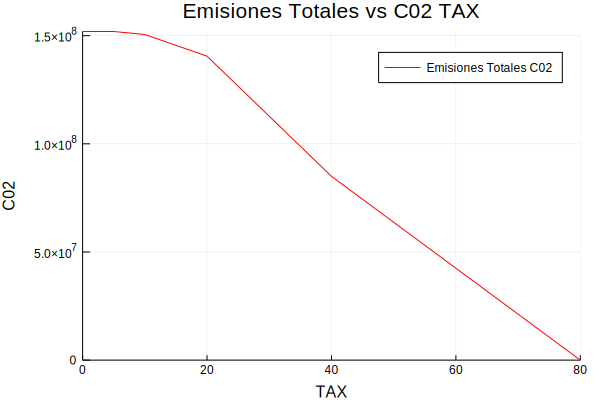

In [11]:
pn = @df df plot(:TAX, :Emisiones_Total, colour = :red, title = "Emisiones Totales vs C02 TAX",label = "Emisiones Totales C02", xaxis = "TAX", yaxis = "C02")

In [12]:
png(pn, "plots")

# pregunta 2a

In [2]:
# Sets
G  = ["CCGT","Coal","Solar"];    # Tecnologias 
P = [i for i=1:24];  # Bloques representativos del dia

D = readxl("Datos2.xlsx", "Datos P2!B2:B25"); # demanda en el periodo i

W_solar = readxl("Datos2.xlsx", "Datos P2!C2:C25"); # factor de planta maximo por periodo i

W = Dict{Tuple{String,Int64},Float64}();

for i=G,t=P
    try
    W[i,t]
    catch error
       if isa(error, KeyError)
           if i=="Solar"
                W[i,t] = W_solar[t]
           else
                W[i,t] = 1.0
           end
       end
    end
end



In [3]:
Dneta = zeros(5,24)

pp = 0;
for k in [0,300,600,900,1300]
    pp=pp+1;
    for t in  P
        Dneta[pp,t] = D[t] - k*W["Solar",t];
    end
end

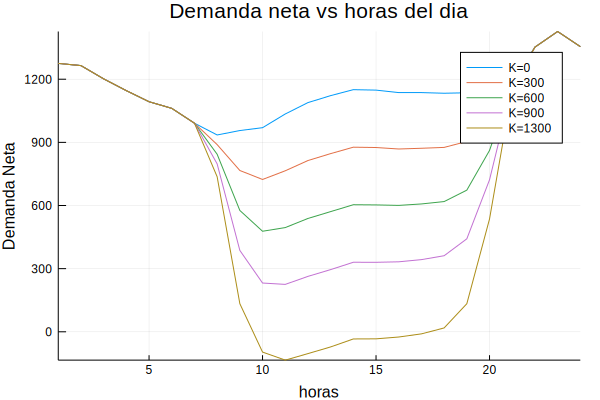

In [5]:
pn = plot(Dneta',title = "Demanda neta vs horas del dia", xaxis = "horas", yaxis = "Demanda Neta",label=["K=0","K=300","K=600","K=900","K=1300"])

In [6]:
png(pn, "plots2")

# pregunta 2b

In [39]:
# Parameters
K = Dict(              # capacida de generador
  "CCGT"   => 500.0,
  "Coal"   => 1000.0,
  "Solar"  => 1200.0
);

Km = Dict(              # capacida de generador
  "CCGT"   => 0,
  "Coal"   => 100,
  "Solar"  => 0
);


MC = Dict(              # costos marginales
  "CCGT"   => 60,
  "Coal"   => 30,
  "Solar"  => 0
);

H=1;

VOLL = 500;

# Modelo declaracion
P3 = Model(solver=GurobiSolver(Presolve=0)); # planificacion a largo plazo

# Variables
@variable(P3, q3[G,P] >= 0); # cantidad de energia generada de la tecnologia i en el periodo t
@variable(P3, u3[P] >= 0); # variable desprendimiento
@variable(P3, x3[G] >=0); # capacidad instalada
@variable(P3, e3[G,P], Bin);

# funcion objetivo
@objective(P3, :Min, sum(MC[i]*q3[i,t]*H for i in G, t in P) + sum(VOLL*u3[t]*H for t in P));

# Balance demanda energia
@constraint(P3, balance3[t=P], sum(q3[i,t] for i in G) + u3[t] == D[t]);

# restriccion de capacidad por bloques
@constraint(P3, capacidad3[i=G,t=P], q3[i,t] <= W[i,t]*K[i]*e3[i,t]);

@constraint(P3, minimotecnico3[i=G,t=P], q3[i,t] >= Km[i]*e3[i,t]);

@constraint(P3, [t=P],e3["CCGT",t] + e3["Solar",t] == 2);

#@constraint(P3, sum(q3["Solar",t] for t=P) >= sum(W["Solar",t]*K["Solar"] for t=P) -80);
    
solve(P3)

Academic license - for non-commercial use only
Optimize a model with 192 rows, 171 columns and 374 nonzeros
Variable types: 99 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+03]
Found heuristic solution: objective 1.372080e+07
Variable types: 99 continuous, 72 integer (72 binary)

Root relaxation: objective 5.333358e+05, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 533335.753    0    5 1.3721e+07 533335.753  96.1%     -    0s
H    0     0                    539531.61916 533335.753  1.15%     -    0s
*    0     0               0    538214.28954 538214.290  0.00%     -    0s

Cutting planes:
  Gomory: 5
  Implied bound: 5

Explored 1 nodes (52 simplex iterations) in 0.01 seconds
Thread count was 4 (of

:Optimal

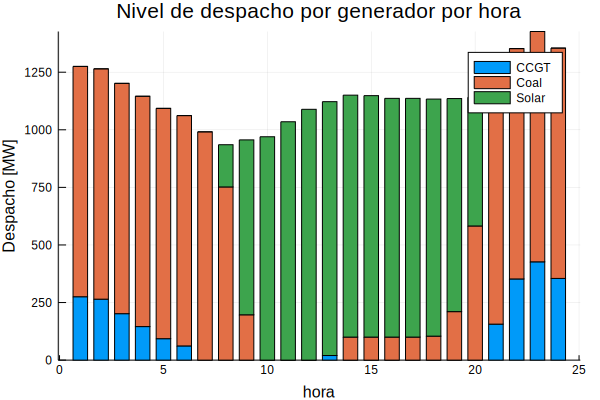

In [40]:
df = DataFrame(Hora = 0, CCGT = 0.0, Coal = 0.0, Solar = 0.0)

for t=P
    push!(df,[t getvalue(q3["CCGT",t]) getvalue(q3["Coal",t]) getvalue(q3["Solar",t])])
end

deleterows!(df,find(df[:,:Hora].==0))

pn = @df df groupedbar(:Hora,[:CCGT :Coal :Solar], bar_position = :stack, bar_width=0.7,yaxis = "Despacho [MW]",xaxis = "hora",title = "Nivel de despacho por generador por hora")



In [41]:
png(pn, "plots3")

In [42]:

A = sum(W["Solar",t]*K["Solar"] for t=P) - sum(getvalue(q3["Solar",t]) for t=P)

B = A + sum(getvalue(q3["Solar",t]) for t=P)

C = A/B

[A B C]

1×3 Array{Float64,2}:
 213.529  12066.5  0.017696

# pregunta 2c

In [81]:
# Parameters
K = Dict(              # capacida de generador
  "CCGT"   => 500.0,
  "Coal"   => 1000.0,
  "Solar"  => 1200.0
);

Km = Dict(              # capacida de generador
  "CCGT"   => 0,
  "Coal"   => 100,
  "Solar"  => 0
);


MC = Dict(              # costos marginales
  "CCGT"   => 60,
  "Coal"   => 30,
  "Solar"  => 0
);

H=1;

VOLL = 500;

# Modelo declaracion
P3 = Model(solver=GurobiSolver(Presolve=0)); # planificacion a largo plazo

# Variables
@variable(P3, q3[G,P] >= 0); # cantidad de energia generada de la tecnologia i en el periodo t
@variable(P3, u3[P] >= 0); # variable desprendimiento
@variable(P3, x3[G] >=0); # capacidad instalada
@variable(P3, e3[G,P], Bin);

# funcion objetivo
@objective(P3, :Min, sum(MC[i]*q3[i,t]*H for i in G, t in P) + sum(VOLL*u3[t]*H for t in P));

# Balance demanda energia
@constraint(P3, balance3[t=P], sum(q3[i,t] for i in G) + u3[t] == D[t]);

# restriccion de capacidad por bloques
@constraint(P3, capacidad3[i=G,t=P], q3[i,t] <= W[i,t]*K[i]*e3[i,t]);

@constraint(P3, minimotecnico3[i=G,t=P], q3[i,t] >= Km[i]*e3[i,t]);

@constraint(P3, [t=P],e3["CCGT",t] + e3["Solar",t] == 2);

# restriccion de rampas de partida y parada

@constraint(P3, [t=P], q3["Coal",t] - (in(t,[1])?1050:q3["Coal",t-1]) <= 50);

@constraint(P3, [t=P], (in(t,[1])?1050:q3["Coal",t-1]) - q3["Coal",t] <= 50);

#@constraint(P3, sum(q3["Solar",t] for t=P) >= sum(W["Solar",t]*K["Solar"] for t=P) -80);
    
solve(P3)

Academic license - for non-commercial use only
Optimize a model with 240 rows, 171 columns and 468 nonzeros
Variable types: 99 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+03]
Variable types: 99 continuous, 72 integer (72 binary)

Root relaxation: objective 7.403971e+05, 39 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    740397.14272 740397.143  0.00%     -    0s

Explored 0 nodes (39 simplex iterations) in 0.00 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 740397 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.403971427197e+05, best bound 7.403971427197e+05, gap 0.0000%


:Optimal

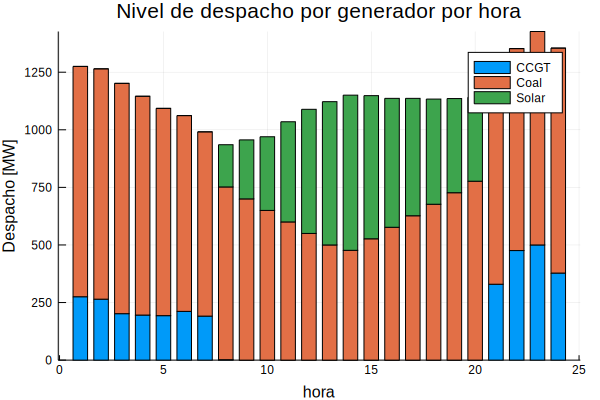

In [82]:
df = DataFrame(Hora = 0, CCGT = 0.0, Coal = 0.0, Solar = 0.0)

for t=P
    push!(df,[t getvalue(q3["CCGT",t]) getvalue(q3["Coal",t]) getvalue(q3["Solar",t])])
end

deleterows!(df,find(df[:,:Hora].==0))

pn = @df df groupedbar(:Hora,[:CCGT :Coal :Solar], bar_position = :stack, bar_width=0.7,yaxis = "Despacho [MW]",xaxis = "hora",title = "Nivel de despacho por generador por hora")



In [77]:
png(pn, "plots4")

In [83]:
A = sum(W["Solar",t]*K["Solar"] for t=P) - sum(getvalue(q3["Solar",t]) for t=P)

B = A + sum(getvalue(q3["Solar",t]) for t=P)

C = A/B

[A B C]

1×3 Array{Float64,2}:
 6086.99  12066.5  0.504453

In [47]:
# Parameters
K = Dict(              # capacida de generador
  "CCGT"   => 500.0,
  "Coal"   => 1000.0,
  "Solar"  => 1200.0
);

Km = Dict(              # capacida de generador
  "CCGT"   => 0,
  "Coal"   => 100,
  "Solar"  => 0
);


MC = Dict(              # costos marginales
  "CCGT"   => 60,
  "Coal"   => 30,
  "Solar"  => 0
);

H=1;

VOLL = 500;

# Modelo declaracion
P3 = Model(solver=GurobiSolver(Presolve=0)); # planificacion a largo plazo

# Variables
@variable(P3, q3[G,P] >= 0); # cantidad de energia generada de la tecnologia i en el periodo t
@variable(P3, u3[P] >= 0); # variable desprendimiento
@variable(P3, x3[G] >=0); # capacidad instalada
@variable(P3, e3[G,P], Bin);

# funcion objetivo
@objective(P3, :Min, sum(MC[i]*q3[i,t]*H for i in G, t in P) + sum(VOLL*u3[t]*H for t in P));

# Balance demanda energia
@constraint(P3, balance3[t=P], sum(q3[i,t] for i in G) + u3[t] == D[t]);

# restriccion de capacidad por bloques
@constraint(P3, capacidad3[i=G,t=P], q3[i,t] <= W[i,t]*K[i]*e3[i,t]);

#@constraint(P3, minimotecnico3[i=G,t=P], q3[i,t] >= Km[i]*e3[i,t]);

@constraint(P3, [t=P],e3["CCGT",t] + e3["Solar",t] == 2);

# restriccion de rampas de partida y parada

#@constraint(P3, [t=P], q3["Coal",t] - (in(t,[1])?0:q3["Coal",t-1]) <= 50);

#@constraint(P3, [t=P], (in(t,[1])?0:q3["Coal",t-1]) - q3["Coal",t] <= 50);

#@constraint(P3, sum(q3["Solar",t] for t=P) >= sum(W["Solar",t]*K["Solar"] for t=P) -80);
    
solve(P3)

Academic license - for non-commercial use only
Optimize a model with 120 rows, 171 columns and 278 nonzeros
Variable types: 99 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+03]
Found heuristic solution: objective 1.372080e+07
Variable types: 99 continuous, 72 integer (72 binary)

Root relaxation: objective 5.333358e+05, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    533335.75280 533335.753  0.00%     -    0s

Explored 0 nodes (42 simplex iterations) in 0.00 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 533336 1.37208e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.333357528033e+05, best bound 5.333357528033e+05, gap 0.0000%


:Optimal

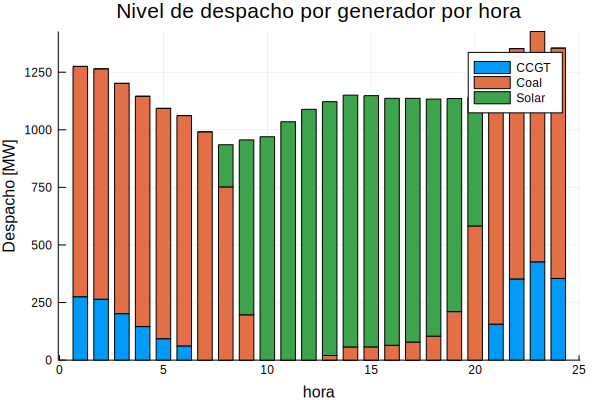

In [48]:
df = DataFrame(Hora = 0, CCGT = 0.0, Coal = 0.0, Solar = 0.0)

for t=P
    push!(df,[t getvalue(q3["CCGT",t]) getvalue(q3["Coal",t]) getvalue(q3["Solar",t])])
end

deleterows!(df,find(df[:,:Hora].==0))

pn = @df df groupedbar(:Hora,[:CCGT :Coal :Solar], bar_position = :stack, bar_width=0.7,yaxis = "Despacho [MW]",xaxis = "hora",title = "Nivel de despacho por generador por hora")


In [49]:
png(pn, "plots5")

In [50]:
A = sum(W["Solar",t]*K["Solar"] for t=P) - sum(getvalue(q3["Solar",t]) for t=P)

B = A + sum(getvalue(q3["Solar",t]) for t=P)

C = A/B

[A B C]

1×3 Array{Float64,2}:
 70.9011  12066.5  0.00587585

# pregunta 2d